# ACTION RECOGNITION WITH VideoMAE TRANSFORMER ON UCF101 SUBSET
BY ARYAN S BHARDWAJ

## Project Overview  
I have implemented a video action classification pipeline using the VideoMAE transformer model to recognize human actions from video clips. VideoMAE leverages masked autoencoding for efficient spatiotemporal learning, making it ideal for frame-based video classification tasks.

This project uses a curated subset of the UCF101 dataset and demonstrates how to extract, preprocess, and fine-tune a transformer model on real-world human activity data.

## Dataset: UCF101 Subset  
UCF101 is a widely-used benchmark dataset for human action recognition in videos. In this assignment, I’ve worked with a subset containing the following five action classes:
- HorseRiding  
- PoleVault  
- LongJump  
- Skiing  
- JavelinThrow  

Each video has been split into individual RGB frames and organized into train, validation, and test directories based on its class. This structure enables efficient preprocessing, visualization, and model training using fixed-length frame sequences.

### Library Overview

| Library | Purpose |
|--------|---------|
| `torch` | Deep learning operations, model loading, predictions |
| `transformers` | Pretrained VideoMAE |
| `torchvision` | Image transforms |
| `cv2` | Frame extraction |
| `yt_dlp` | Downloading YouTube videos |
| `imbalanced-learn` | Balancing dataset using oversampling |

## 1. Dataset: Download, Extract, Drop Classes

I've downloaded the dataset from the original host website and extracted the rar file. Then, I've run a loop over the dataset to remove classes not required for our assignment.

In [ ]:
import os

!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar -O /content/UCF101.rar
!unrar x /content/UCF101.rar /content/ucf101_cleaned/
!mv /content/ucf101_cleaned/UCF-101 /content/ucf_clips

keep_these = ['horseriding', 'polevault', 'longjump', 'javelinthrow', 'skiing']
for item in os.listdir("/content/ucf_clips"):
    if item.lower().replace(" ", "") not in keep_these:
        os.system(f'rm -rf "/content/ucf_clips/{item}"')

print("Classes kept:")
print(sorted(os.listdir("/content/ucf_clips")))

Streaming output truncated to the last 5000 lines.
Extracting  /content/ucf101_cleaned/UCF-101/PlayingGuitar/v_PlayingGuitar_g06_c07.avi      62%  OK 
Extracting  /content/ucf101_cleaned/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c01.avi      62%  OK 
Extracting  /content/ucf101_cleaned/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c02.avi      62%  OK 
Extracting  /content/ucf101_cleaned/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c03.avi      62%  OK 
Extracting  /content/ucf101_cleaned/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c04.avi      62%  OK 
Extracting  /content/ucf101_cleaned/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c05.avi      62%  OK 
Extracting  /content/ucf101_cleaned/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c06.avi      62%  OK 
Extracting  /content/ucf101_cleaned/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c07.avi      62%  OK 
Extracting  /content/ucf101_cleaned/UCF-101/PlayingGuitar/v_PlayingGuitar_g08

## 2. Train/Validation/Test Split

`Why Split Before Frame Extraction:`

- `Each split contains completely separate videos`, preserving temporal coherence.
- There is `no data leakage` — frames from the same video won't appear in multiple splits.

I've created an `80/10/10 split` of the video in class folder. This allows:
- Model training on a large portion of the data
- Validation during training for monitoring and early stopping
- A final test set to access generalization

This is performed dynamically for each class in the dataset.

In [ ]:
import os
import random
import shutil
from tqdm import tqdm

original_data_dir = '/content/ucf_clips'
split_output_dir = '/content/ucf_split'

random.seed(42)

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

splits = ['train', 'val', 'test']
for split in splits:
    for cls in os.listdir(original_data_dir):
        os.makedirs(os.path.join(split_output_dir, split, cls), exist_ok=True)

for cls in tqdm(os.listdir(original_data_dir), desc="Splitting dataset"):
    cls_folder = os.path.join(original_data_dir, cls)
    videos = sorted(os.listdir(cls_folder))
    random.shuffle(videos)

    n_total = len(videos)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)

    train_videos = videos[:n_train]
    val_videos = videos[n_train:n_train + n_val]
    test_videos = videos[n_train + n_val:]

    for split_name, split_videos in zip(splits, [train_videos, val_videos, test_videos]):
        for video in split_videos:
            src = os.path.join(cls_folder, video)
            dst = os.path.join(split_output_dir, split_name, cls, video)
            shutil.copy(src, dst)

Splitting dataset: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


## 3. Frame Extraction from Videos

I've decided to work with `raw frames over feature sequences because raw frames preserve spatio-temporal relationships` critical for actions like pole vault. Also, I'm `not using a CNN based feature extractor to avoid CNN-induced bias from pre-extracted features`.

For VideoMAE, this decision aligns well with its masked video modeling approach, where the model learns to reconstruct missing patches across both space and time, making the preservation of raw structure critical.

We extract `16 frames` from each video using uniform sampling. This ensures:

- `Input consistency` across videos of varying lengths  
- `Efficient use of compute` by capturing motion without redundancy  
- `Alignment with VideoMAE`’s input expectations

This preprocessing technique is also consistent with approaches in the original VideoMAE paper and other transformer-based models like TimeSformer and ViViT.

In [ ]:
!pip install opencv-python-headless

In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm
video_split_root = "/content/ucf_split"
frame_output_root = "/content/frames_ucf101"

NUM_FRAMES = 16
IMAGE_SIZE = (224, 224)

for split in ['train', 'val', 'test']:
  split_path = os.path.join(video_split_root, split)

  for class_name in os.listdir(split_path):
    class_path = os.path.join(split_path, class_name)
    videos = os.listdir(class_path)

    for video_name in tqdm(videos, desc=f"{split}/{class_name}", unit="video"):
      video_path = os.path.join(class_path, video_name)
      video_id = os.path.splitext(video_name)[0]

      out_dir = os.path.join(frame_output_root, split, class_name, video_id)
      os.makedirs(out_dir, exist_ok=True)

      cap = cv2.VideoCapture(video_path)
      total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

      if total == 0:
        print(f"No frames found in {video_path}")
        cap.release()
        continue

      indices = np.linspace(0, total-1, NUM_FRAMES, dtype=int)

      for i, frame_index in enumerate(indices):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        ret, frame = cap.read()
        if not ret:
          continue

        resized = cv2.resize(frame, IMAGE_SIZE)
        fname = f"frame_{i+1:03}.jpg"
        cv2.imwrite(os.path.join(out_dir, fname), resized)

      cap.release()

test/JavelinThrow: 100%|██████████| 13/13 [00:01<00:00,  9.54video/s]


# 4. EXPLORATORY DATA ANALYSIS

Before model training, I performed detailed EDA to better understand the UCF101 subset.

## 4.1 Class Distribution

Checking the `number of videos per class across the training, validation, and test sets`. This reveals class balance and whether any category might dominate model learning.

In [ ]:
import os

frames_root = "/content/frames_ucf101"

for split in ["train", "val", "test"]:
    split_dir = os.path.join(frames_root, split)
    total_videos = 0
    print(f"\n{split.upper()} SPLIT:")

    for class_name in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, class_name)
        num_videos = len(os.listdir(class_dir))
        print(f"  {class_name}: {num_videos}")
        total_videos += num_videos

    print(f"Total video clips in {split}: {total_videos}")


TRAIN SPLIT:
  HorseRiding: 131
  PoleVault: 119
  LongJump: 104
  Skiing: 108
  JavelinThrow: 93
Total video clips in train: 555

VAL SPLIT:
  HorseRiding: 16
  PoleVault: 14
  LongJump: 13
  Skiing: 13
  JavelinThrow: 11
Total video clips in val: 67

TEST SPLIT:
  HorseRiding: 17
  PoleVault: 16
  LongJump: 14
  Skiing: 14
  JavelinThrow: 13
Total video clips in test: 74


`The class distribution is fairly balanced`, with no extreme class imbalance that could bias the model. This suggests that accuracy metrics across classes should be comparable and meaningful.

## 4.2 Sample Frame Visualization

Visualizing a few random frames from each class to ensure that the frame extraction process worked correctly.

To qualitatively assess the data, I visualized one random frame per class from each split (train, validation, test). This helps confirm that:
- The frame extraction process worked correctly.
- Actions are visually distinguishable.
- Resolution and aspect ratio are consistent.

Such inspection is crucial before training, especially for video models where input quality heavily impacts performance.

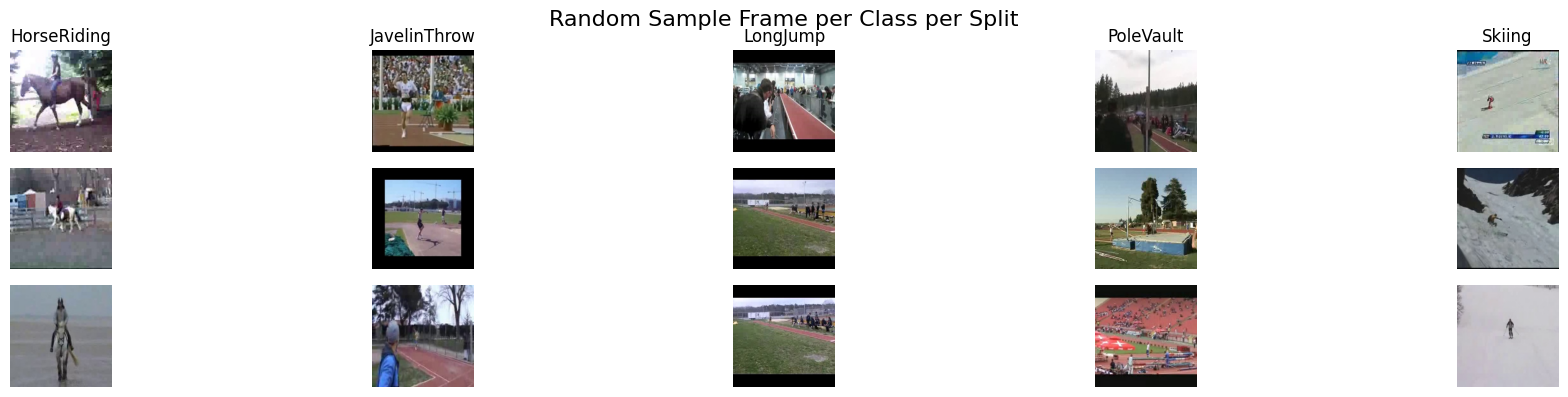

In [ ]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

root = "/content/frames_ucf101"
splits = ["train", "val", "test"]
class_names = sorted(os.listdir(os.path.join(root, "train")))  # assuming all splits have same class list

fig, axes = plt.subplots(len(splits), len(class_names), figsize=(4 * len(class_names), 4))
fig.suptitle("Random Sample Frame per Class per Split", fontsize=16)

for i, split in enumerate(splits):
    split_path = os.path.join(root, split)

    for j, cls in enumerate(class_names):
        cls_path = os.path.join(split_path, cls)
        video_folders = os.listdir(cls_path)
        chosen_video = random.choice(video_folders)
        frame_path = os.path.join(cls_path, chosen_video, "frame_001.jpg")

        image = Image.open(frame_path)
        axes[i, j].imshow(image)
        axes[i, j].axis('off')

        if i == 0:
            axes[i, j].set_title(cls, fontsize=12)
        if j == 0:
            axes[i, j].set_ylabel(split.upper(), fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

Now visualizing all 16 frames of a few random videos

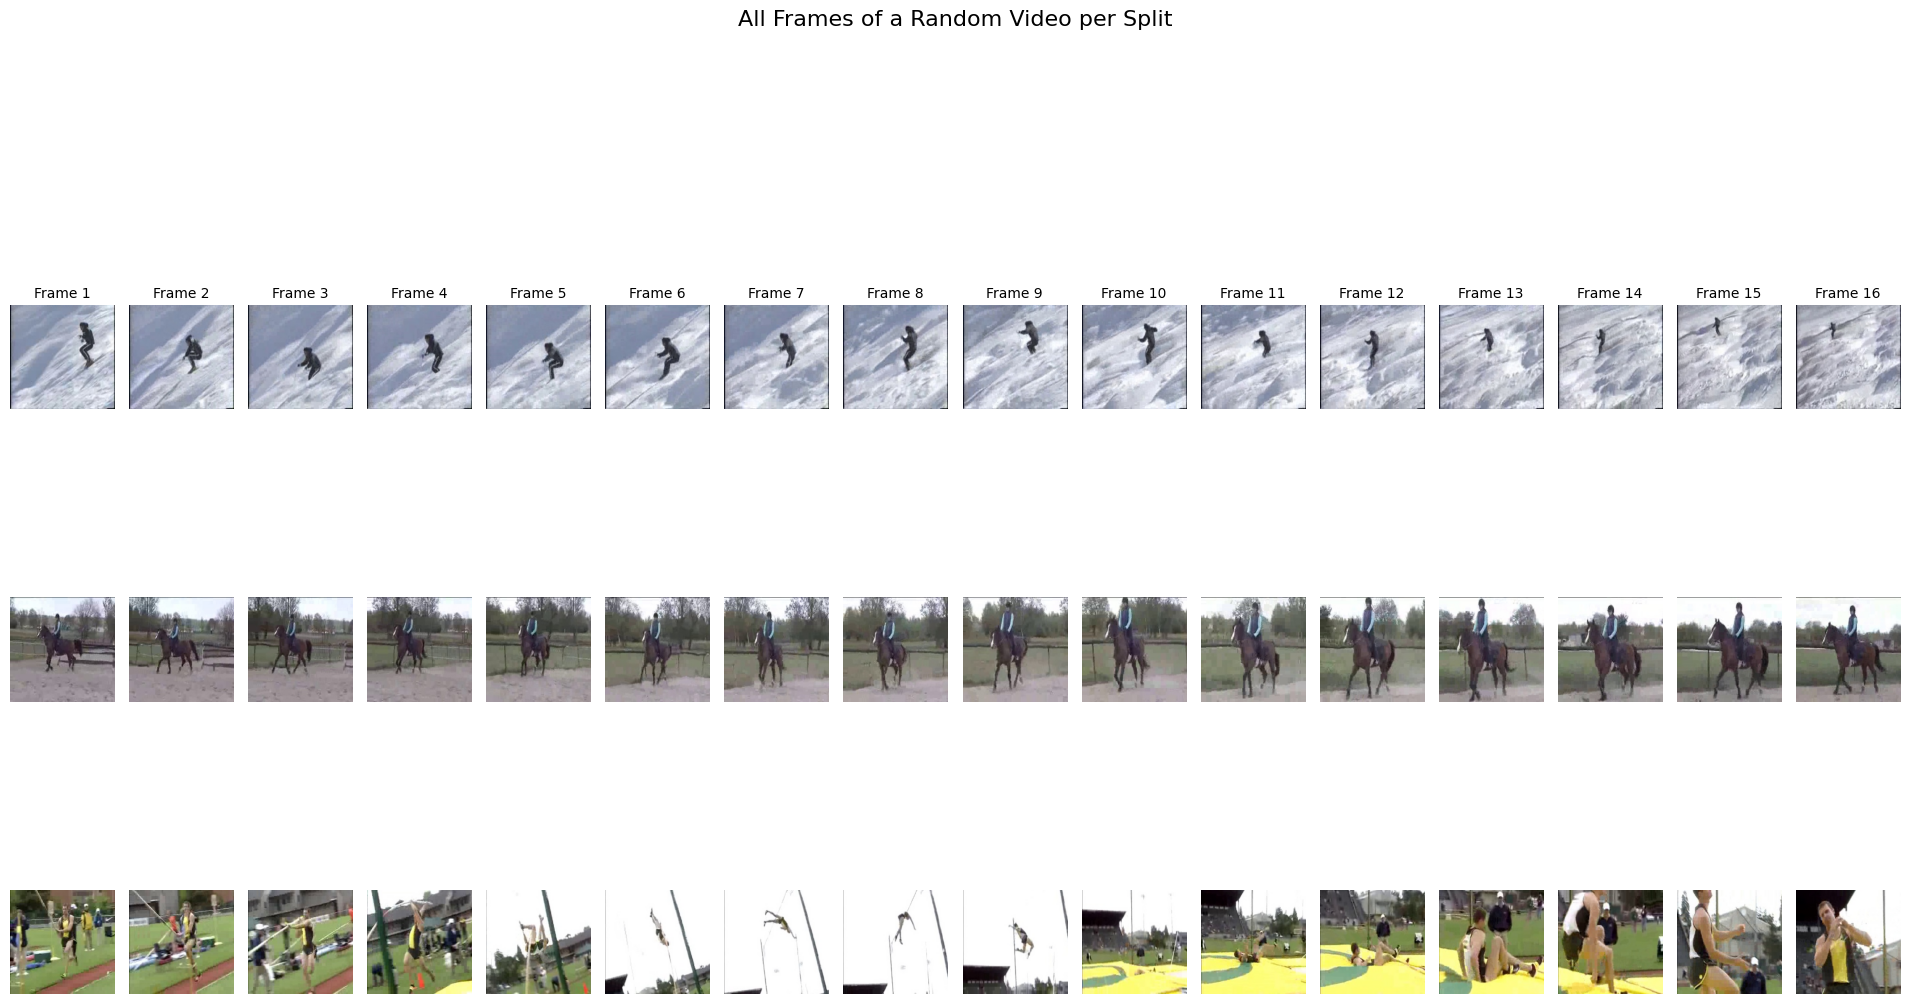

In [ ]:
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

root = "/content/frames_ucf101"
splits = ["train", "val", "test"]
num_frames_to_display = 16

fig, axes = plt.subplots(len(splits), num_frames_to_display, figsize=(num_frames_to_display * 1.2, 4 * len(splits)))
fig.suptitle("All Frames of a Random Video per Split", fontsize=16)

for i, split in enumerate(splits):
    split_path = os.path.join(root, split)
    classes = sorted(os.listdir(split_path))
    chosen_class = random.choice(classes)
    class_path = os.path.join(split_path, chosen_class)
    video_folders = sorted(os.listdir(class_path))
    chosen_video = random.choice(video_folders)
    video_path = os.path.join(class_path, chosen_video)

    for j in range(num_frames_to_display):
        frame_file = f"frame_{j+1:03}.jpg"
        frame_path = os.path.join(video_path, frame_file)

        if os.path.exists(frame_path):
            image = Image.open(frame_path)
            axes[i, j].imshow(image)
        else:
            axes[i, j].text(0.5, 0.5, "N/A", ha='center', va='center')

        axes[i, j].axis('off')

        if i == 0:
            axes[i, j].set_title(f"Frame {j+1}", fontsize=10)
        if j == 0:
            axes[i, j].set_ylabel(f"{split.upper()}\n{chosen_class}\n{chosen_video}", fontsize=10)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

## 4.3 Frame Count Distribution per Video

Since VideoMAE requires a fixed number of frames, it's important to understand how many frames each video originally had.
- Videos with too few frames may lead to oversampling of similar content, while longer ones are downsampled, potentially losing key motion cues.
- This helps justify the decision to pad short videos and sample evenly from longer ones.

We'll now plot a histogram of frame counts per video for all three splits.

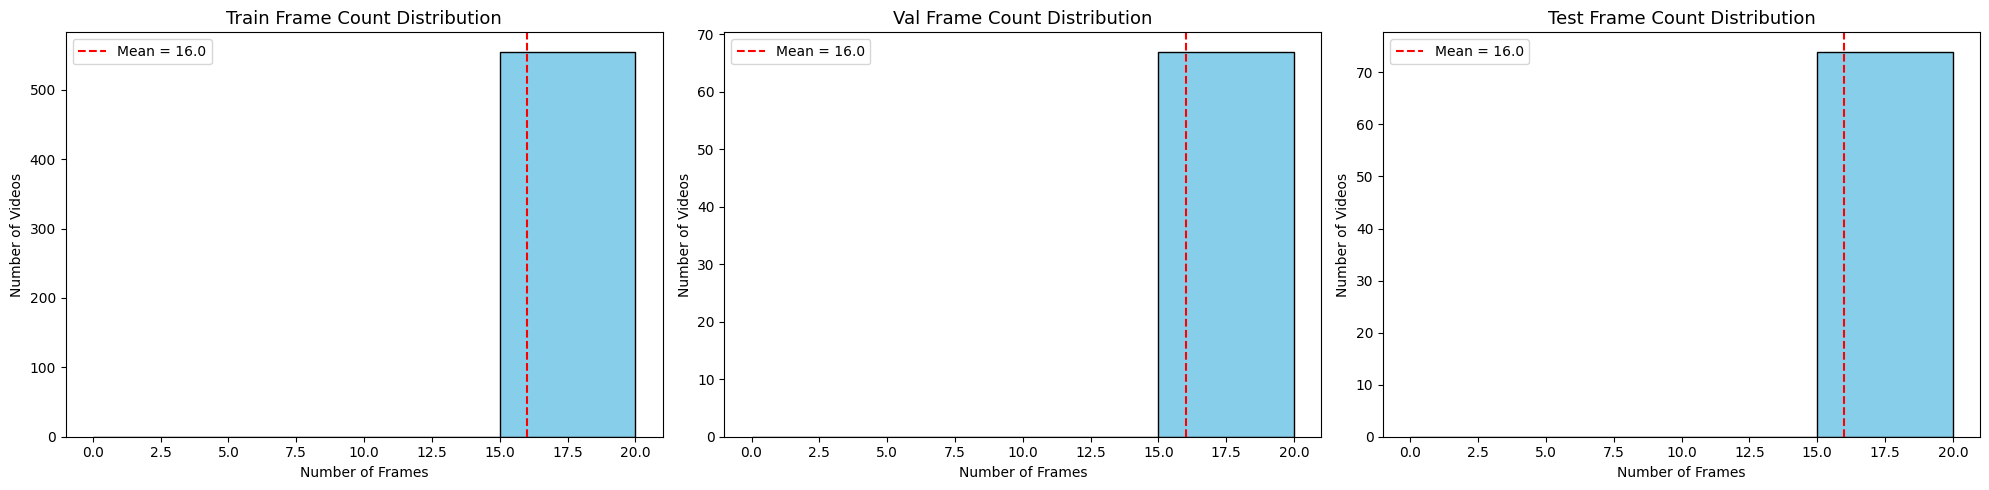

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

root = "/content/frames_ucf101"
splits = ["train", "val", "test"]
frame_counts = {split: [] for split in splits}

for split in splits:
    split_path = os.path.join(root, split)
    for cls in os.listdir(split_path):
        class_path = os.path.join(split_path, cls)
        for video_folder in os.listdir(class_path):
            video_path = os.path.join(class_path, video_folder)
            frame_files = [f for f in os.listdir(video_path) if f.endswith('.jpg')]
            frame_counts[split].append(len(frame_files))

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, split in enumerate(splits):
    counts = frame_counts[split]
    if not counts:
        continue
    bins = np.arange(0, max(counts)+5, 5)

    axes[i].hist(counts, bins=bins, color='skyblue', edgecolor='black')
    axes[i].set_title(f"{split.capitalize()} Frame Count Distribution", fontsize=13)
    axes[i].set_xlabel("Number of Frames")
    axes[i].set_ylabel("Number of Videos")
    axes[i].axvline(np.mean(counts), color='red', linestyle='--', label=f"Mean = {np.mean(counts):.1f}")
    axes[i].legend()

plt.tight_layout()
plt.show()

## 5. Data Augmentation

To improve generalization and avoid overfitting—especially considering the limited dataset size—I apply spatial augmentations to the video clips.

Since VideoMAE expects a fixed number of RGB frames, it's important to apply augmentations consistently across all frames in a clip to preserve temporal coherence.

### Spatial Augmentations (Applied to Each Frame):
- Resize: All frames are resized to 224×224 to match the ViT backbone's input size.
- Random Horizontal Flip: Introduces left-right invariance in motion.
- Color Jitter: Simulates lighting and color variations across environments.
- Normalization: Uses ImageNet mean/std values for compatibility with pretrained ViT-based backbones.

> These augmentations are applied only to the training set. Validation and test sets are kept untouched except for resizing and normalization to ensure consistent and fair evaluation.


In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## 6. Why I Built a Custom DataLoader

my dataset is already:
- Organized into folders by class/split
- Preprocessed into individual image frames
- Frame counts fixed at 16

Hence, I created a custom `VideoDataset` class to:
- Load these saved frames for each video
- Apply spatial augmentations (e.g., resizing, flipping, jittering)
- Apply temporal augmentations (e.g., time reversal, local frame shuffle)
- Return the clip in `[T, C H, W]` format, as expected by VideoMAE.

In [ ]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import cv2

CLASSES = sorted(os.listdir("/content/frames_ucf101/train"))

class VideoDatasetFromSplit(Dataset):
    def __init__(self, split_dir, transform=None, num_frames=16):
        self.video_clips = []
        self.labels = []
        self.transform = transform
        self.num_frames = num_frames

        for class_idx, class_name in enumerate(CLASSES):
            class_path = os.path.join(split_dir, class_name)
            if not os.path.exists(class_path):
                continue

            for video_folder in os.listdir(class_path):
                video_path = os.path.join(class_path, video_folder)
                frames = sorted(os.listdir(video_path))
                total_clips = len(frames) // num_frames

                for i in range(total_clips):
                    clip = frames[i * num_frames : (i + 1) * num_frames]
                    if len(clip) == num_frames:
                        self.video_clips.append([os.path.join(video_path, f) for f in clip])
                        self.labels.append(class_idx)

    def __len__(self):
        return len(self.video_clips)

    def __getitem__(self, idx):
        frame_paths = self.video_clips[idx]
        frames = []

        for path in frame_paths:
            image = cv2.imread(path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if self.transform:
                image = self.transform(image)
            frames.append(image)

        frames = torch.stack(frames)  # Shape: (T, C, H, W)
        label = self.labels[idx]
        return frames, label


### 6.1 Data Loaders

Now that the `VideoDatasetFromSplit` class has been defined with both spatial and temporal augmentations, I instantiate data loaders for training, validation, and testing.

- The training set uses temporal augmentation to boost generalization.
- Validation and test sets remain deterministic to ensure reproducibility.


In [ ]:
train_dataset = VideoDatasetFromSplit("/content/frames_ucf101/train", transform=train_transform)
val_dataset = VideoDatasetFromSplit("/content/frames_ucf101/val", transform=val_test_transform)
test_dataset = VideoDatasetFromSplit("/content/frames_ucf101/test", transform=val_test_transform)

from torch.utils.data import DataLoader

BATCH_SIZE = 2
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 6.2 Sample Clip Visualization as GIF

To visually verify how each video clip looks after preprocessing, we convert a tensor of 16 frames into a GIF.

In [ ]:
import imageio
import numpy as np
from IPython.display import Image, display

def unnormalize_img(img, mean, std):
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return np.clip(img, 0, 255)

def create_gif(video_tensor, filename="sample.gif", mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    frames = []
    for frame in video_tensor:
        frame_np = frame.permute(1, 2, 0).cpu().numpy()  # (C, H, W) → (H, W, C)
        unnorm_frame = unnormalize_img(frame_np, np.array(mean), np.array(std))
        frames.append(unnorm_frame.astype(np.uint8))
    imageio.mimsave(filename, frames, fps=5)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    gif_filename = create_gif(video_tensor, gif_name)
    display(Image(filename=gif_filename))


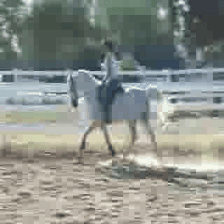

In [ ]:
video_batch, label_batch = next(iter(test_loader))
sample_video = video_batch[0]
display_gif(sample_video, "sample_clip.gif")

## 7. Model Selection & Setup: Why VideoMAE?

For my video classification task on a UCF101 subset, I chose VideoMAE — a masked autoencoding transformer that has shown exceptional performance and efficiency.

Instead of using older transformer architectures like ViViT or TimeSformer, I selected `VideoMAE-base`, pretrained on Kinetics-400, and available on Hugging Face with plug-and-play support.

### Why Not Other Transformers?

| Model       | Pretraining | Frames | Support | Accuracy (UCF101) | Hugging Face |
|-------------|-------------|--------|---------|-------------------|---------------|
| ViViT       | Supervised  | 32–64  | ✅       | ~96%              | ✅ Yes          |
| TimeSformer | Supervised  | 8–16   | ✅       | ~94%              | ✅ Yes         |
| VideoMAE| Self-Supervised | 16 | ✅       | 98.1%         | ✅ Yes         |

→ VideoMAE outperforms ViViT and TimeSformer, using `far less computation due to masking while being lighter to fine-tune`.

---

### PapersWithCode Ranking

On the official [PapersWithCode UCF101 Leaderboard](https://paperswithcode.com/sota/action-recognition-in-videos-on-ucf101), VideoMAE ranks #2 overall, and #1 among publicly available pretrained transformer models.

---

### Architectural Advantages of VideoMAE

- `Masked Modeling`: Learns from only 10% of frames, forcing deeper temporal understanding
- `Strong Generalization`: Robust to out-of-distribution videos (e.g., YouTube)
- `Efficient`: No quadratic cost from full attention like ViViT; works well with 16.

<p align="center">
  <img src="https://github.com/MCG-NJU/VideoMAE/raw/main/figures/framework.png" alt="VideoMAE Architecture" width="600"/>
</p>

---

### Why I Chose `MCG-NJU/videomae-base`

- Hugging Face pretrained weights = faster experimentation
- Native support for `Trainer API` and `AutoImageProcessor`
- Compatible with my already preprocessed RGB frame dataset
- Clean integration into a lightweight training loop

---

### Summary

| Requirement                     | VideoMAE Satisfies? |
|-------------------------------|---------------------|
| Transformer-based architecture | ✅                  |
| Frames or sequence input       | ✅ [T, C, H, W]      |
| Hugging Face support           | ✅                  |
| GPU-efficient training         | ✅                  |

---

## 7.1 Setting Up Device For Training and Pulling Model From HuggingFace Hub

In [ ]:
import torch
import torch.nn as nn
from transformers import VideoMAEForVideoClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model_name = "MCG-NJU/videomae-base"
model = VideoMAEForVideoClassification.from_pretrained(model_name)
model.config.num_labels = len(CLASSES)
model.classifier = torch.nn.Linear(model.classifier.in_features, len(CLASSES))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/377M [00:00<?, ?B/s]

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VideoMAEForVideoClassification(
  (videomae): VideoMAEModel(
    (embeddings): VideoMAEEmbeddings(
      (patch_embeddings): VideoMAEPatchEmbeddings(
        (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
      )
    )
    (encoder): VideoMAEEncoder(
      (layer): ModuleList(
        (0-11): 12 x VideoMAELayer(
          (attention): VideoMAEAttention(
            (attention): VideoMAESelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
            )
            (output): VideoMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): VideoMAEIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
    

Model Summary

In [ ]:
!pip install torchinfo

from torchinfo import summary

summary(
    model,
    input_size=(4, 16, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params"],
    depth=4
)

Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #
VideoMAEForVideoClassification                               [4, 16, 3, 224, 224]      [4, 5]                    --
├─VideoMAEModel: 1-1                                         [4, 16, 3, 224, 224]      [4, 1568, 768]            --
│    └─VideoMAEEmbeddings: 2-1                               [4, 16, 3, 224, 224]      [4, 1568, 768]            --
│    │    └─VideoMAEPatchEmbeddings: 3-1                     [4, 16, 3, 224, 224]      [4, 1568, 768]            --
│    │    │    └─Conv3d: 4-1                                 [4, 3, 16, 224, 224]      [4, 768, 8, 14, 14]       1,180,416
│    └─VideoMAEEncoder: 2-2                                  [4, 1568, 768]            [4, 1568, 768]            --
│    │    └─ModuleList: 3-2                                  --                        --                        --
│    │    │    └─VideoMAELayer: 4-2                         

## 7.2 Optimizer and Loss Setup

In [ ]:
from torch.optim import AdamW

lr = 1e-5
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
num_training_steps = len(train_loader) * 10
warmup_steps = int(0.1 * num_training_steps)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=warmup_steps)

criterion = nn.CrossEntropyLoss()

## 7.4 Early Stopping

In [ ]:
best_f1 = 0
patience = 3
patience_counter = 0

## 7.4 Training Loop

Evaluation Metrics

To evaluate model performance on the validation and test sets, I compute:

- `Accuracy:` Overall correctness
- `Precision:` Fraction of positive predictions that were correct
- `Recall:` Fraction of actual positives that were correctly identified
- `F1 Score:` Balance between precision and recall

`This cell trains the VideoMAE` model with the following components:

- `Training Phase`
  - Each batch of video clips is fed to the model.  
  - Cross-entropy loss is computed and backpropagated.  
  - Optimizer updates the model weights.  
  - A warmup scheduler adjusts the learning rate during initial steps for smoother convergence.

- `Validation Phase`  
  - After every epoch, the model is evaluated on the validation set.  
  - Key metrics are computed: Loss, Accuracy, Precision, Recall, and F1-Score.

- `Early Stopping`
  - The model is checkpointed whenever validation F1-score improves.  
  - If the F1-score doesn’t improve for `patience` consecutive epochs, training stops early.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0

    with torch.no_grad():
        for videos, labels in loader:
            videos, labels = videos.to(device), labels.to(device)
            videos = videos.permute(0, 1, 2, 3, 4)

            outputs = model(pixel_values=videos).logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    avg_loss = total_loss / len(loader)
    return avg_loss, acc, prec, rec, f1

In [ ]:
# Training loop with validation, warmup, and early stopping
best_f1 = 0
patience = 3
patience_counter = 0

EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for i, (videos, labels) in enumerate(train_loader):
        videos, labels = videos.to(device), labels.to(device)
        videos = videos.permute(0, 1, 2, 3, 4)

        optimizer.zero_grad()
        outputs = model(pixel_values=videos).logits
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # Warmup scheduler step
        if epoch * len(train_loader) + i < warmup_steps:
            scheduler.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        if (i + 1) % 10 == 0 or i == 0:
            print(f"[Epoch {epoch + 1}] Step {i+1}/{len(train_loader)} > Loss: {loss.item():.4f}")

    train_loss = running_loss / len(train_loader)
    print(f"\nEpoch {epoch + 1} Train Loss: {train_loss:.4f}")

    # Validation
    val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate(model, val_loader)

    print(f"\nEpoch {epoch + 1} Validation Summary:")
    print(f"Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f} | Precision: {val_prec:.4f} | Recall: {val_rec:.4f} | F1-Score: {val_f1:.4f}")

    # Early stopping
    if val_f1 > best_f1:
        best_f1 = val_f1
        patience_counter = 0
        print("F1 improved - model saved.")
        torch.save(model.state_dict(), "best_videomae_model.pt")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

[Epoch 1] Step 1/277 > Loss: 1.0729
[Epoch 1] Step 10/277 > Loss: 0.6739
[Epoch 1] Step 20/277 > Loss: 1.3901
[Epoch 1] Step 30/277 > Loss: 0.4620
[Epoch 1] Step 40/277 > Loss: 0.3670
[Epoch 1] Step 50/277 > Loss: 1.0177
[Epoch 1] Step 60/277 > Loss: 0.7676
[Epoch 1] Step 70/277 > Loss: 0.4007
[Epoch 1] Step 80/277 > Loss: 0.7907
[Epoch 1] Step 90/277 > Loss: 0.4693
[Epoch 1] Step 100/277 > Loss: 1.5844
[Epoch 1] Step 110/277 > Loss: 0.6197
[Epoch 1] Step 120/277 > Loss: 0.4257
[Epoch 1] Step 130/277 > Loss: 0.2059
[Epoch 1] Step 140/277 > Loss: 0.1330
[Epoch 1] Step 150/277 > Loss: 0.3999
[Epoch 1] Step 160/277 > Loss: 1.3701
[Epoch 1] Step 170/277 > Loss: 0.8967
[Epoch 1] Step 180/277 > Loss: 0.6846
[Epoch 1] Step 190/277 > Loss: 0.3585
[Epoch 1] Step 200/277 > Loss: 0.5515
[Epoch 1] Step 210/277 > Loss: 0.3148
[Epoch 1] Step 220/277 > Loss: 0.1270
[Epoch 1] Step 230/277 > Loss: 0.1773
[Epoch 1] Step 240/277 > Loss: 0.5215
[Epoch 1] Step 250/277 > Loss: 0.0833
[Epoch 1] Step 260/277 

## 7.5 Testing Loop

In [ ]:
def test_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0

    with torch.no_grad():
        for videos, labels in test_loader:
            videos, labels = videos.to(device), labels.to(device)
            videos = videos.permute(0, 1, 2, 3, 4)

            outputs = model(pixel_values=videos).logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    avg_loss = total_loss / len(test_loader)

    print("\nTest Set Evaluation:")
    print(f"Loss: {avg_loss:.4f} | Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1-Score: {f1:.4f}")


In [ ]:
model.load_state_dict(torch.load("best_videomae_model.pt"))
model.to(device)

test_model(model, test_loader)


Test Set Evaluation:
Loss: 0.0745 | Accuracy: 0.9730 | Precision: 0.9703 | Recall: 0.9703 | F1-Score: 0.9703


## 8. Visualizations

              precision    recall  f1-score   support

 HorseRiding       1.00      1.00      1.00        17
JavelinThrow       0.92      0.92      0.92        13
    LongJump       0.93      0.93      0.93        14
   PoleVault       1.00      1.00      1.00        16
      Skiing       1.00      1.00      1.00        14

    accuracy                           0.97        74
   macro avg       0.97      0.97      0.97        74
weighted avg       0.97      0.97      0.97        74



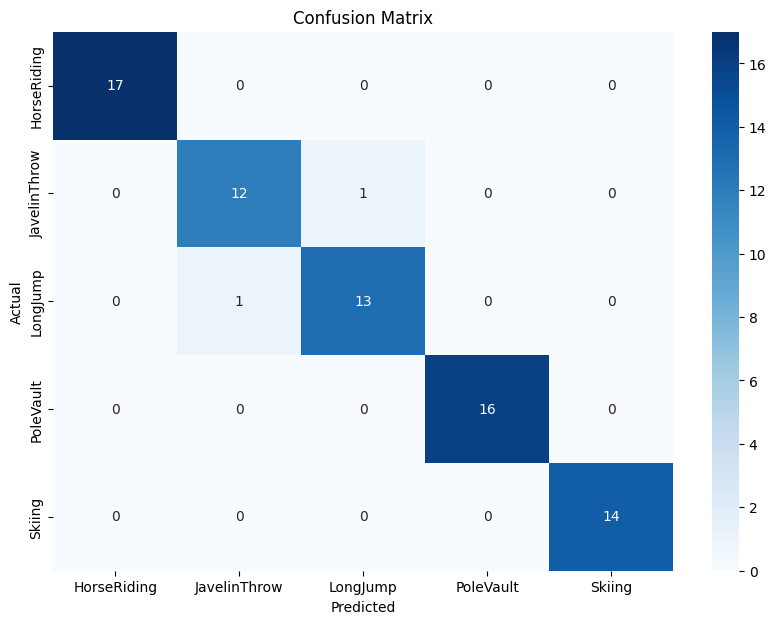

In [ ]:
all_preds, all_labels = [], []

model.eval()
with torch.no_grad():
    for videos, labels in test_loader:
        videos, labels = videos.to(device), labels.to(device)
        videos = videos.permute(0, 1, 2, 3, 4)
        outputs = model(pixel_values=videos).logits
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print(classification_report(all_labels, all_preds, target_names=CLASSES))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, loader, class_names):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for videos, labels in loader:
            videos, labels = videos.to(device), labels.to(device)
            videos = videos.permute(0, 1, 2, 3, 4)
            outputs = model(pixel_values=videos).logits
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix on Test Set")
    plt.show()


## 8. Downloading YouTube Video and Testing our Model on those Videos

In [ ]:
!pip install yt-dlp opencv-python-headless imageio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 45.3 MB/s eta 0:00:00


In [ ]:
import yt_dlp
import cv2
import torch
import numpy as np
import os
import imageio
from IPython.display import Image, display

def download_youtube_video(url, output_path="yt_video.mp4"):
    ydl_opts = {
        'format': 'mp4',
        'outtmpl': output_path,
        'quiet': True
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])
    return output_path

def extract_16_frames(video_path, size=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames < 16:
        raise ValueError("Video is too short (<16 frames)")

    indices = np.linspace(0, total_frames - 1, 16, dtype=int)
    frames = []

    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            continue
        frame = cv2.resize(frame, size)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_normalized = frame_rgb / 255.0
        frame_normalized = (frame_normalized - mean) / std
        tensor_frame = torch.tensor(frame_normalized).permute(2, 0, 1).float()
        frames.append((frame_rgb, tensor_frame))

    cap.release()
    return frames

def create_gif_from_frames(raw_frames, filename="yt_clip.gif"):
    imageio.mimsave(filename, raw_frames, fps=5)
    display(Image(filename=filename))

def predict_action(model, tensor_frames, class_names):
    model.eval()
    video_tensor = torch.stack(tensor_frames)
    input_tensor = video_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(pixel_values=input_tensor)
        probs = torch.softmax(outputs.logits, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()

    return class_names[pred_idx], probs[0][pred_idx].item()


Ground Truth: HorseRiding


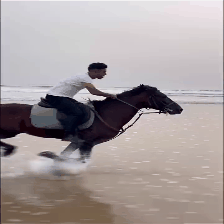

Predicted: HorseRiding (91.27% confidence)

Ground Truth: PoleVault


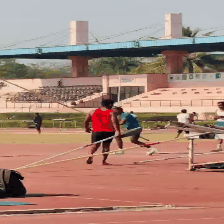

Predicted: PoleVault (99.11% confidence)

Ground Truth: LongJump


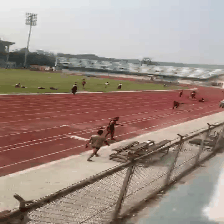

Predicted: LongJump (87.83% confidence)

Ground Truth: JavelinThrow


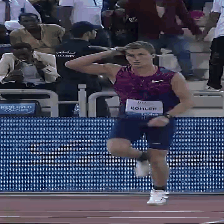

Predicted: JavelinThrow (94.41% confidence)

Ground Truth: Skiing


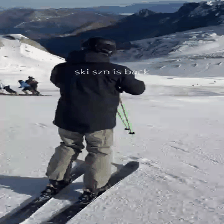

Predicted: HorseRiding (50.02% confidence)


In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

model.load_state_dict(torch.load("best_videomae_model.pt"))
model.to(device)

youtube_videos = {
    "HorseRiding": "https://www.youtube.com/shorts/dFzeqoPwhig",
    "PoleVault": "https://www.youtube.com/shorts/4VLhBY6P1Bo",
    "LongJump": "https://www.youtube.com/shorts/NbMwIZGrxZY",
    "JavelinThrow": "https://www.youtube.com/shorts/xglb09M3MxU",
    "Skiing": "https://www.youtube.com/shorts/_PpwYA1csVI"
}

for label, url in youtube_videos.items():
    print(f"\nGround Truth: {label}")
    try:
        video_path = download_youtube_video(url, output_path=f"{label}.mp4")
        raw_and_tensor_frames = extract_16_frames(video_path)

        raw_frames = [f[0] for f in raw_and_tensor_frames]
        tensor_frames = [f[1] for f in raw_and_tensor_frames]

        gif_name = f"{label}_yt.gif"
        create_gif_from_frames(raw_frames, gif_name)

        predicted_class, confidence = predict_action(model, tensor_frames, CLASSES)
        print(f"Predicted: {predicted_class} ({confidence:.2%} confidence)")

        os.remove(video_path)

    except Exception as e:
        print(f"Error processing {label}: {e}")